In [1379]:
# Dependencies imported
from pymongo import MongoClient
from pprint import pprint
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

Import source datasets into MongoDB using the following imports

mongoimport --type csv -d project3 -c emissions --headerline --drop GCB2022v27_MtCO2_flat.csv

mongoimport --type csv -d project3 -c population --headerline --drop world_population.csv

mongoimport --type csv -d project3 -c gdp --headerline --drop gdp.csv

In [1380]:
# Instance of MongoClient created
mongo = MongoClient(port=27017)

In [1381]:
# Database names listed, to ensure that our database has been created
mongo.list_database_names()

['admin',
 'autosaurus',
 'classDB',
 'config',
 'epa',
 'fruits_db',
 'local',
 'met',
 'petsitly_marketing',
 'project3',
 'uk_food']

In [1382]:
# Database is named
db = mongo["project3"]

In [1383]:
# Collection names are listed to ensure that our datasets have been imported
db.list_collection_names()

['population', 'gdp', 'emissions']

In [1384]:
# Colections are named
emissions = db["emissions"]
population = db["population"]
gdp = db["gdp"]

In [1385]:
# 1 record in the emission collection is printed to gauge its structure
pprint(emissions.find_one())

{'Cement': '',
 'Coal': '',
 'Country': 'Afghanistan',
 'Flaring': '',
 'Gas': '',
 'ISO 3166-1 alpha-3': 'AFG',
 'Oil': '',
 'Other': '',
 'Per Capita': '',
 'Total': 0,
 'Year': 1750,
 '_id': ObjectId('66523c4896b122622ff55ef4')}


In [1386]:
# As the dataset contains dates ranging from 1700, set up a query to filter for only years after 1921
emissions_query = {"Year" : {"$gte" : 1922}}

# Select desired columns with a field query
emissions_fields = {"Country", "ISO 3166-1 alpha-3", "Year", "Total", "Coal", "Oil", "Gas", "Cement", "Flaring", "Other"}

In [1387]:
# Create an emissions DataFrame with the selected query and fields applied
emissions_df = pd.DataFrame(emissions.find(emissions_query, emissions_fields))

# Remove unwanted columns and rename remaining columns
del emissions_df["_id"]
emissions_df = emissions_df.rename(columns= {"ISO 3166-1 alpha-3" : "Code"})

# After inspecting the DataFrame at later stage, it was noted that the country of St. Kitts and Nevis was duplicated under a different name; this filter removes the duplicate
emissions_df = emissions_df.loc[emissions_df["Country"] != "St. Kitts-Nevis-Anguilla"]

emissions_df.head()

,Country,Code,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,Afghanistan,AFG,1922,0,,,,,,
1,Afghanistan,AFG,1923,0,,,,,,
2,Afghanistan,AFG,1924,0,,,,,,
3,Afghanistan,AFG,1925,0,,,,,,
4,Afghanistan,AFG,1927,0,,,,,,


In [1391]:
# 1 record in the population collection is printed to gauge its structure
pprint(population.find_one())

{'1970 Population': 10752971,
 '1980 Population': 12486631,
 '1990 Population': 10694796,
 '2000 Population': 19542982,
 '2010 Population': 28189672,
 '2015 Population': 33753499,
 '2020 Population': 38972230,
 '2022 Population': 41128771,
 'Area (km²)': 652230,
 'CCA3': 'AFG',
 'Capital': 'Kabul',
 'Continent': 'Asia',
 'Country/Territory': 'Afghanistan',
 'Density (per km²)': 63.0587,
 'Growth Rate': 1.0257,
 'Rank': 36,
 'World Population Percentage': 0.52,
 '_id': ObjectId('665390023c40ae0fc867eb44')}


In [1392]:
# Filter the population collection with a query to return all records, but only for certain columns
population_query = {}
population_fields = {"Country/Territory", "CCA3", "Continent", "1970 Population", "1980 Population", "1990 Population", "2000 Population", "2010 Population", "2020 Population"}

In [1393]:
# Create a population DataFrame with the selected query and fields applied
population_df = pd.DataFrame(population.find(population_query, population_fields))

# Remove unwanted ID column and rename remaining columns
del population_df["_id"]
population_df = population_df.rename(columns= {"CCA3" : "Code"})

population_df.head()

,Code,Country/Territory,Continent,2020 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population
0,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971
1,ALB,Albania,Europe,2866849,2913399,3182021,3295066,2941651,2324731
2,DZA,Algeria,Africa,43451666,35856344,30774621,25518074,18739378,13795915
3,ASM,American Samoa,Oceania,46189,54849,58230,47818,32886,27075
4,AND,Andorra,Europe,77700,71519,66097,53569,35611,19860


In [1388]:
# 1 record in the gdp collection is printed to gauge its structure
pprint(gdp.find_one())

{'1960': '',
 '1961': '',
 '1962': '',
 '1963': '',
 '1964': '',
 '1965': '',
 '1966': '',
 '1967': '',
 '1968': '',
 '1969': '',
 '1970': '',
 '1971': '',
 '1972': '',
 '1973': '',
 '1974': '',
 '1975': '',
 '1976': '',
 '1977': '',
 '1978': '',
 '1979': '',
 '1980': '',
 '1981': '',
 '1982': '',
 '1983': '',
 '1984': '',
 '1985': '',
 '1986': 405463417.11746,
 '1987': 487602457.746416,
 '1988': 596423607.114715,
 '1989': 695304363.031101,
 '1990': 764887117.194486,
 '1991': 872138715.083799,
 '1992': 958463184.357542,
 '1993': 1082979720.67039,
 '1994': 1245688268.15642,
 '1995': 1320474860.3352,
 '1996': 1379960893.85475,
 '1997': 1531944134.07821,
 '1998': 1665100558.65922,
 '1999': 1722798882.68156,
 '2000': 1873452513.96648,
 '2001': 1920111731.84358,
 '2002': 1941340782.12291,
 '2003': 2021229050.27933,
 '2004': 2228491620.11173,
 '2005': 2330726256.98324,
 '2006': 2424581005.58659,
 '2007': 2615083798.88268,
 '2008': 2745251396.64804,
 '2009': 2498882681.56425,
 '2010': 2390502

In [1389]:
# gdp collection is filtered with a query to return all records, but only for certain columns (dates)
gdp_query = {}
gdp_fields = {"Country Name", "Code", "1970", "1980", "1990", "2000", "2010", "2020"}

In [1390]:
# gdp DataFrame is created, with the selected query and fields applied
gdp_df = pd.DataFrame(gdp.find(gdp_query, gdp_fields))

# Unwanted ID column deleted
del gdp_df["_id"]

gdp_df.head()

,Country Name,Code,1970,1980,1990,2000,2010,2020
0,Aruba,ABW,,,764887117.194486,1873452513.96648,2390502793.29609,
1,Africa Eastern and Southern,AFE,40315782854.298599,156512735720.641998,212336051488.558014,283952504751.697998,847409491176.197021,920792331527.745972
2,Afghanistan,AFG,1748886595.55556,3641723321.99546,,,15856678596.148001,20116137325.820599
3,Africa Western and Central,AFW,23504608014.6703,112031316716.518005,121802185300.139008,140407973778.931,591582966686.496948,784587603322.865967
4,Angola,AGO,,5934073603.54849,11236275842.7358,9129634978.33773,83799496611.200394,58375976292.967796


In [1394]:
# As the 3 different datasets contain different names for countries, they are merged, so the country names can be standardised across all 3. Thry are merged on the "Code" column, as these are ubiquitously recognised codes
merged_df = pd.merge(population_df, gdp_df, on="Code", how="inner").merge(emissions_df, on="Code", how="inner")

merged_df.head()

,Code,Country/Territory,Continent,2020 Population,2010 Population,2000 Population,1990 Population,1980 Population,1970 Population,Country Name,...,2020,Country,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1922,0,,,,,,
1,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1923,0,,,,,,
2,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1924,0,,,,,,
3,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1925,0,,,,,,
4,AFG,Afghanistan,Asia,38972230,28189672,19542982,10694796,12486631,10752971,Afghanistan,...,20116137325.820599,Afghanistan,1927,0,,,,,,


In [1395]:
# Cleaned emissions DataFrame is created by extracting and cleaning columns from the merged DataFrame
emissions_df_cleaned = pd.DataFrame(merged_df[["Country/Territory", "Code", "Year", "Total", "Coal", "Oil", "Gas", "Cement", "Flaring", "Other"]])
emissions_df_cleaned = emissions_df_cleaned.rename(columns= {"Country/Territory" : "Country"})
emissions_df_cleaned = emissions_df_cleaned.sort_values(["Country", "Year"])
emissions_df_cleaned = emissions_df_cleaned.reset_index(drop=True)

emissions_df_cleaned.head()

,Country,Code,Year,Total,Coal,Oil,Gas,Cement,Flaring,Other
0,Afghanistan,AFG,1922,0,,,,,,
1,Afghanistan,AFG,1923,0,,,,,,
2,Afghanistan,AFG,1924,0,,,,,,
3,Afghanistan,AFG,1925,0,,,,,,
4,Afghanistan,AFG,1926,0,,,,,,


In [1396]:
# Cleaned emissions DataFrame dtypes are checked and are found to be incorrect
emissions_df_cleaned.dtypes         

Country    object
Code       object
Year        int64
Total      object
Coal       object
Oil        object
Gas        object
Cement     object
Flaring    object
Other      object
dtype: object

In [1397]:
# After further investigation, it was realised that these incorrect dtypes were due to a TypeError. This is rectifed by replacing all spaces with "0"
emissions_df_cleaned = emissions_df_cleaned.replace('',0)

# dtypes are checked again and are still incorrect
emissions_df.dtypes

Country    object
Code       object
Year        int64
Total      object
Coal       object
Oil        object
Gas        object
Cement     object
Flaring    object
Other      object
dtype: object

In [1398]:
# "astype" is used to force the selected columns to float type
emissions_df_cleaned["Total"] = emissions_df_cleaned["Total"].astype("float")
emissions_df_cleaned["Coal"] = emissions_df_cleaned["Coal"].astype("float")
emissions_df_cleaned["Oil"] = emissions_df_cleaned["Oil"].astype("float")
emissions_df_cleaned["Gas"] = emissions_df_cleaned["Gas"].astype("float")
emissions_df_cleaned["Cement"] = emissions_df_cleaned["Cement"].astype("float")
emissions_df_cleaned["Flaring"] = emissions_df_cleaned["Flaring"].astype("float")
emissions_df_cleaned["Other"] = emissions_df_cleaned["Other"].astype("float")

# dtypes are checked again and are now correct
emissions_df_cleaned.dtypes

Country     object
Code        object
Year         int64
Total      float64
Coal       float64
Oil        float64
Gas        float64
Cement     float64
Flaring    float64
Other      float64
dtype: object

In [1399]:
# Cleaned population DataFrame is created by extracting and cleaning columns from the merged DataFrame
population_df_cleaned = merged_df.drop_duplicates("Code")
population_df_cleaned = population_df_cleaned[["Country/Territory", "Code", "Continent", "1970 Population", "1980 Population", "1990 Population", "2000 Population", "2010 Population", "2020 Population"]]
population_df_cleaned = population_df_cleaned.rename(columns= {"Country/Territory" : "Country"})
population_df_cleaned = population_df_cleaned.sort_values("Country")
population_df_cleaned = population_df_cleaned.reset_index(drop=True)

population_df_cleaned.head()

,Country,Code,Continent,1970 Population,1980 Population,1990 Population,2000 Population,2010 Population,2020 Population
0,Afghanistan,AFG,Asia,10752971,12486631,10694796,19542982,28189672,38972230
1,Albania,ALB,Europe,2324731,2941651,3295066,3182021,2913399,2866849
2,Algeria,DZA,Africa,13795915,18739378,25518074,30774621,35856344,43451666
3,Andorra,AND,Europe,19860,35611,53569,66097,71519,77700
4,Angola,AGO,Africa,6029700,8330047,11828638,16394062,23364185,33428485


In [1400]:
# Cleaned population DataFrame dtypes are checked and are found to be correct; no further action needed
population_df_cleaned.dtypes

Country            object
Code               object
Continent          object
1970 Population     int64
1980 Population     int64
1990 Population     int64
2000 Population     int64
2010 Population     int64
2020 Population     int64
dtype: object

In [1401]:
# Cleaned gdp DataFrame is created by extracting and cleaning columns from the merged DataFrame
gdp_df_cleaned = merged_df.drop_duplicates("Code")
gdp_df_cleaned = gdp_df_cleaned[["Country/Territory", "Code", "Continent", "1970", "1980", "1990", "2000", "2010", "2020"]]
gdp_df_cleaned = gdp_df_cleaned.rename(columns= {"Country/Territory" : "Country"})
gdp_df_cleaned = gdp_df_cleaned.sort_values("Country")
gdp_df_cleaned = gdp_df_cleaned.reset_index(drop=True)

gdp_df_cleaned.head()

,Country,Code,Continent,1970,1980,1990,2000,2010,2020
0,Afghanistan,AFG,Asia,1748886595.55556,3641723321.99546,,,15856678596.148001,20116137325.820599
1,Albania,ALB,Europe,,,2028553750.0,3480355258.04122,11926922828.9911,14887629268.2927
2,Algeria,DZA,Africa,4863487492.65763,42346380830.770798,62048562947.2509,54790392746.193901,161207270185.25,145009181490.619995
3,Andorra,AND,Europe,78619206.085096,446416105.825017,1029048481.88051,1429049198.45218,3449966856.68832,
4,Angola,AGO,Africa,,5934073603.54849,11236275842.7358,9129634978.33773,83799496611.200394,58375976292.967796


In [1402]:
# Cleaned population DataFrame dtypes are checked and are found to be incorrect
gdp_df_cleaned.dtypes

Country      object
Code         object
Continent    object
1970         object
1980         object
1990         object
2000         object
2010         object
2020         object
dtype: object

In [1403]:
# After further investigation, it was realised that these incorrect dtypes were due to a TypeError. This is rectifed by replacing all spaces with "0"
gdp_df_cleaned = gdp_df_cleaned.replace('',0)

# dtypes are checked again and are now correct
gdp_df_cleaned.dtypes

Country       object
Code          object
Continent     object
1970         float64
1980         float64
1990         float64
2000         float64
2010         float64
2020         float64
dtype: object

In [1404]:
gdp_df_cleaned.head()

,Country,Code,Continent,1970,1980,1990,2000,2010,2020
0,Afghanistan,AFG,Asia,1.748887e+09,3.641723e+09,0.000000e+00,0.000000e+00,1.585668e+10,2.011614e+10
1,Albania,ALB,Europe,0.000000e+00,0.000000e+00,2.028554e+09,3.480355e+09,1.192692e+10,1.488763e+10
2,Algeria,DZA,Africa,4.863487e+09,4.234638e+10,6.204856e+10,5.479039e+10,1.612073e+11,1.450092e+11
3,Andorra,AND,Europe,7.861921e+07,4.464161e+08,1.029048e+09,1.429049e+09,3.449967e+09,0.000000e+00
4,Angola,AGO,Africa,0.000000e+00,5.934074e+09,1.123628e+10,9.129635e+09,8.379950e+10,5.837598e+10


In [1405]:
# Countries DataFrame is created by extracting and cleaning columns from the cleaned population DataFrame.
countries_df = population_df_cleaned[["Country", "Code", "Continent"]]
countries_df = countries_df.sort_values("Country")
countries_df = countries_df.reset_index(drop=True)

countries_df.head()

,Country,Code,Continent
0,Afghanistan,AFG,Asia
1,Albania,ALB,Europe
2,Algeria,DZA,Africa
3,Andorra,AND,Europe
4,Angola,AGO,Africa


In [1406]:
# Country DataFrame dtypes are checked and are correct
countries_df.dtypes

Country      object
Code         object
Continent    object
dtype: object

In [1407]:
# 4 DataFrames have now  been created; each have the same number of countries, with the same names
# The 4 DataFrames are exported as CSVs to the output folder, and can be used for future projects, if desired
emissions_df_cleaned.to_csv("output/emissions.csv", index=False)
population_df_cleaned.to_csv("output/population.csv", index=False)
gdp_df_cleaned.to_csv("output/gdp.csv", index=False)
countries_df.to_csv("output/countries.csv", index=False)

In [1408]:
# The 4 DataFrames are also JSONified, to be used in this project, for the JavaScript powered dashboard
emissions_json = emissions_df_cleaned.to_json(orient="records")
population_json = population_df_cleaned.to_json(orient="records")
gdp_json = gdp_df_cleaned.to_json(orient="records")
countries_json = countries_df.to_json(orient="records")

In [1409]:
# The 4 JSONified DataFrames are parsed through "json.loads"
emissions_parsed = json.loads(emissions_json)
population_parsed = json.loads(population_json)
gdp_parsed = json.loads(gdp_json)
countries_parsed = json.loads(countries_json)

In [1413]:
# The 4 parsed JSON outputs are merged into 1 data JSON output, and exported to the output folder, for use in the Javascript element of this project 
with open("output/data.json", "w", encoding="utf8") as output:
    output.write(json.dumps({"emissions" : emissions_parsed,
                             "gdp" : gdp_parsed,
                             "population" : population_parsed,
                             "countries" : countries_parsed}, indent=4))

In [1410]:
barplot_year = int(input("What year would you like to investigate"))
barplot_emission_type = str(input("What emission type would you like to display?").lower().title())

In [1411]:

top10_df = emissions_df_cleaned.loc[(emissions_df_cleaned["Year"] == barplot_year),:]
top10_df = top10_df[["Country", "Code", barplot_emission_type]]
top10_df = top10_df.sort_values(by=barplot_emission_type, ascending=False)
top10_df = top10_df.head(10)
top10_df = top10_df.reset_index(drop=True)
top10_df

,Country,Code,Gas
0,United States,USA,1199.432628
1,Russia,RUS,693.013366
2,United Kingdom,GBR,210.160357
3,Germany,DEU,173.813082
4,Japan,JPN,169.623171
5,Canada,CAN,164.847650
6,Italy,ITA,135.107373
7,Ukraine,UKR,130.104068
8,Iran,IRN,127.653760
9,Uzbekistan,UZB,96.839520


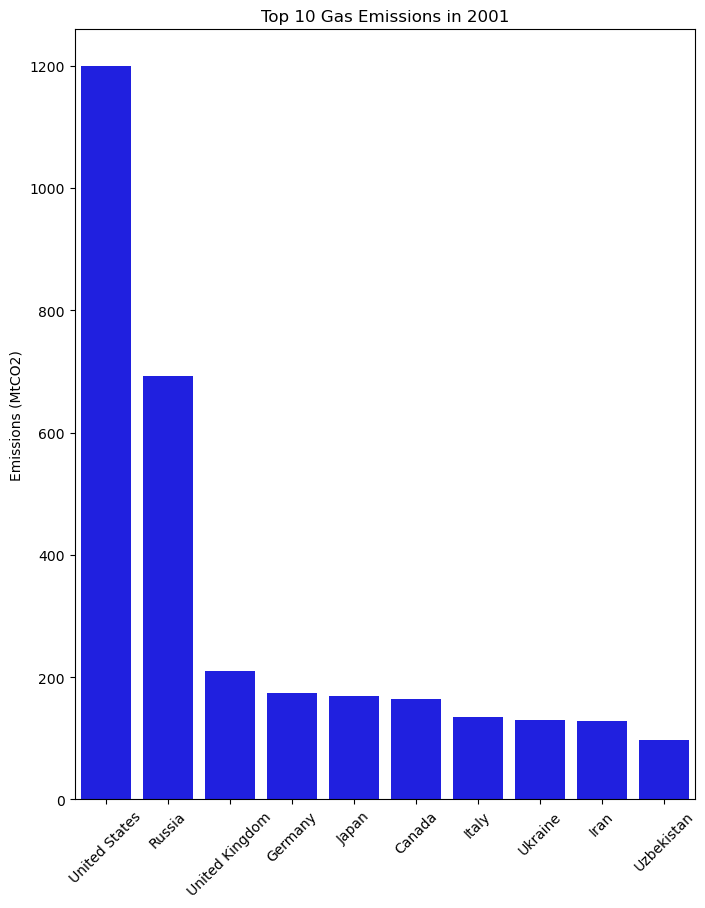

In [1412]:
plt.figure(figsize=(8,10))

barplot = sns.barplot(x = top10_df["Country"],
                      y = top10_df[barplot_emission_type],
                      color="b")

barplot.set(xlabel="", ylabel = "Emissions (MtCO2)")
barplot.set(title=f'Top 10 {barplot_emission_type} Emissions in {barplot_year}')
barplot.set_xticklabels(labels = top10_df["Country"], rotation=45)

plt.savefig(f'output/top10_{barplot_emission_type.lower()}_emissions_{barplot_year}.png', dpi=100)

plt.show()